<a href="https://colab.research.google.com/github/aschauhan241/Stock_Prediction/blob/main/Level_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Level B

Dataset:Same as Level A


Problem Statement:
Create an LSTM Model with a fixed network layout. Create an optimization algorithm to tune the hyperparameters (learning rate, optimizer, etc.) and get higher accuracy of prediction. (same time period as Level A)  
●	Algorithm should optimize the model and save it into a file.

●	Algorithm should also save the final accuracy results of the model into a file

●	Create a serve algorithm that can accept a csv file as input and predict a year's worth of prices for the "Close" value of ASIANPAINTS.


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import random


In [46]:
#Install Kaggle
!pip install -q kaggle

In [47]:
from google.colab import files # Import files from the computer - Upload the kaggle.json file for the dataset
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ashutoshchauhansingh","key":"bce8d3ca95732c3079a7b8b46d3c72a6"}'}

In [48]:
! mkdir ~/.kaggle # Create a Kaggle folder

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [49]:
#Copy the kaggle.json into the folder created

! cp kaggle.json ~/.kaggle/

In [50]:
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

In [51]:
! kaggle datasets download -d rohanrao/nifty50-stock-market-data #Import the required dataset nifty50

nifty50-stock-market-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
!mkdir nifty50 #make a directory to unzip the dataset

mkdir: cannot create directory ‘nifty50’: File exists


In [53]:
! unzip nifty50-stock-market-data.zip -d nifty50 # Unzip the file into the nifty50 directory we created.


Archive:  nifty50-stock-market-data.zip
replace nifty50/ADANIPORTS.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nifty50/ADANIPORTS.csv  
replace nifty50/ASIANPAINT.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: nifty50/ASIANPAINT.csv  
  inflating: nifty50/AXISBANK.csv    
  inflating: nifty50/BAJAJ-AUTO.csv  
  inflating: nifty50/BAJAJFINSV.csv  
  inflating: nifty50/BAJFINANCE.csv  
  inflating: nifty50/BHARTIARTL.csv  
  inflating: nifty50/BPCL.csv        
  inflating: nifty50/BRITANNIA.csv   
  inflating: nifty50/CIPLA.csv       
  inflating: nifty50/COALINDIA.csv   
  inflating: nifty50/DRREDDY.csv     
  inflating: nifty50/EICHERMOT.csv   
  inflating: nifty50/GAIL.csv        
  inflating: nifty50/GRASIM.csv      
  inflating: nifty50/HCLTECH.csv     
  inflating: nifty50/HDFC.csv        
  inflating: nifty50/HDFCBANK.csv    
  inflating: nifty50/HEROMOTOCO.csv  
  inflating: nifty50/HINDALCO.csv    
  inflating: nifty50/HINDUNILVR.csv  
  inflating: nifty

In [54]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/nifty50': ['NESTLEIND.csv', 'SHREECEM.csv', 'nifty50-stock-market-data.zip', 'BPCL.csv', 'RELIANCE.csv', 'HINDUNILVR.csv', 'ULTRACEMCO.csv', 'JSWSTEEL.csv', 'TATAMOTORS.csv', 'BAJAJFINSV.csv', 'INFY.csv', 'INFRATEL.csv', 'UPL.csv', 'VEDL.csv', 'HINDALCO.csv', 'nifty50', 'COALINDIA.csv', 'BRITANNIA.csv', 'DRREDDY.csv', 'ONGC.csv', 'AXISBANK.csv', 'GAIL.csv', 'ADANIPORTS.csv', 'WIPRO.csv', 'kaggle (1).json', 'TCS.csv', 'ASIANPAINT.csv', 'NIFTY50_all.csv', 'INDUSINDBK.csv', 'NTPC.csv', 'BAJFINANCE.csv', 'SUNPHARMA.csv', 'ZEEL.csv', 'LT.csv', 'HEROMOTOCO.csv', 'TITAN.csv', 'MM.csv', 'HDFCBANK.csv', 'KOTAKBANK.csv', 'MARUTI.csv', 'ICICIBANK.csv', 'EICHERMOT.csv', 'POWERGRID.csv', 'ITC.csv', 'HCLTECH.csv', 'HDFC.csv', 'IOC.csv', 'TECHM.csv', 'BAJAJ-AUTO.csv', 'BHARTIARTL.csv', 'SBIN.csv', 'stock_metadata.csv', 'kaggle.json', 'CIPLA.csv', 'GRASIM.csv', 'TATASTEEL.csv']


In [55]:
data_dir = '/content/nifty50'
os.chdir(data_dir)

In [56]:
cwd = os.getcwd()
print("Current working directory: ", cwd)

Current working directory:  /content/nifty50


In [57]:
# Read the CSV file and set 'Date' as the index
df = pd.read_csv("ASIANPAINT.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", drop=False, inplace=True)


In [58]:
# Function to prepare data for LSTM model
def prepare_data(data, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    x_data, y_data = [], []
    for i in range(len(scaled_data) - look_back):
        x_data.append(scaled_data[i:(i + look_back), 0])
        y_data.append(scaled_data[i + look_back, 0])
    return np.array(x_data), np.array(y_data)

In [59]:
# # Function to create the fixed network layout for the LSTM model
# def create_lstm_model(learning_rate=0.001, optimizer='adam'):
#     model = Sequential()
#     model.add(LSTM(64, input_shape=(look_back, 1), activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model


In [60]:
def create_lstm_model(learning_rate=0.01, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, 1), activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout to prevent overfitting
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [61]:
# Function to train the LSTM model and return the accuracy (MSE) on the test set
def train_and_evaluate_model(learning_rate=0.001, optimizer='adam'):
    model = create_lstm_model(learning_rate, optimizer)
    model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)
    predictions = model.predict(test_x)
    mse = mean_squared_error(test_y, predictions)
    return mse, model

In [62]:
# Split the data into train and test sets
train_data_2000_2007 = df['2000':'2007']['Close']
train_data_2009_2015 = df['2009':'2015']['Close']
test_data_2008 = df.loc['2008']['Close']
test_data_2016 = df.loc['2016']['Close']

In [63]:
# Hyperparameter Optimization (Random Search)
look_back = 1  # You can adjust this based on the sequence length you want to consider here we have taken it has 60 days.
num_iterations = 5  # 10 iterations was talking a long time so picked 5
best_mse = float('inf')
best_model = None


In [64]:
# Train and evaluate models for hyperparameter optimization
for i in range(num_iterations):
    learning_rate = 10 ** random.uniform(-5, -2)  # Random learning rate between 0.01 and 0.00001
    optimizer = random.choice(['adam', 'rmsprop', 'sgd'])  # Random optimizer
    train_x, train_y = prepare_data(train_data_2000_2007, look_back)
    test_x, test_y = prepare_data(test_data_2008, look_back)
    mse, model = train_and_evaluate_model(learning_rate, optimizer)
    print(f"Iteration {i+1}: Learning Rate = {learning_rate:.5f}, Optimizer = {optimizer}, MSE = {mse:.5f}")

    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_learning_rate = learning_rate
        best_optimizer = optimizer

# Save the optimized model
best_model.save('best_model.h5')

# Save the final accuracy results
with open('accuracy_results.txt', 'w') as f:
    f.write(f"Best Learning Rate: {best_learning_rate:.5f}\n")
    f.write(f"Best Optimizer: {best_optimizer}\n")
    f.write(f"Best MSE: {best_mse:.5f}")

# Print details of the best model and best accuracy results
print("Best Learning Rate:", best_learning_rate)
print("Best Optimizer:", best_optimizer)
print("Best MSE:", best_mse)

8/8 [==============================] - 0s 3ms/step
Iteration 1: Learning Rate = 0.00194, Optimizer = adam, MSE = 0.00341
8/8 [==============================] - 0s 3ms/step
Iteration 2: Learning Rate = 0.00160, Optimizer = sgd, MSE = 0.04779
8/8 [==============================] - 0s 2ms/step
Iteration 3: Learning Rate = 0.00013, Optimizer = adam, MSE = 0.00347
8/8 [==============================] - 0s 3ms/step
Iteration 4: Learning Rate = 0.00002, Optimizer = adam, MSE = 0.00344
8/8 [==============================] - 0s 2ms/step
Iteration 5: Learning Rate = 0.00653, Optimizer = rmsprop, MSE = 0.00342
Best Learning Rate: 0.0019438258779177972
Best Optimizer: adam
Best MSE: 0.003411907821379519


In [65]:
# Prepare data for plotting predictions for 2008 and 2016
train_x_2009_2015, train_y_2009_2015 = prepare_data(train_data_2009_2015, look_back)
test_x_2016, test_y_2016 = prepare_data(test_data_2016, look_back)

# Make predictions for 2008 and 2016
predictions_2008 = best_model.predict(test_x)
predictions_2016 = best_model.predict(test_x_2016)

8/8 [==============================] - 0s 3ms/step


In [66]:
# Inverse transform the scaled predictions
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data_2000_2007.values.reshape(-1, 1))
predictions_2008 = scaler.inverse_transform(predictions_2008)
scaler.fit(train_data_2009_2015.values.reshape(-1, 1))
predictions_2016 = scaler.inverse_transform(predictions_2016)

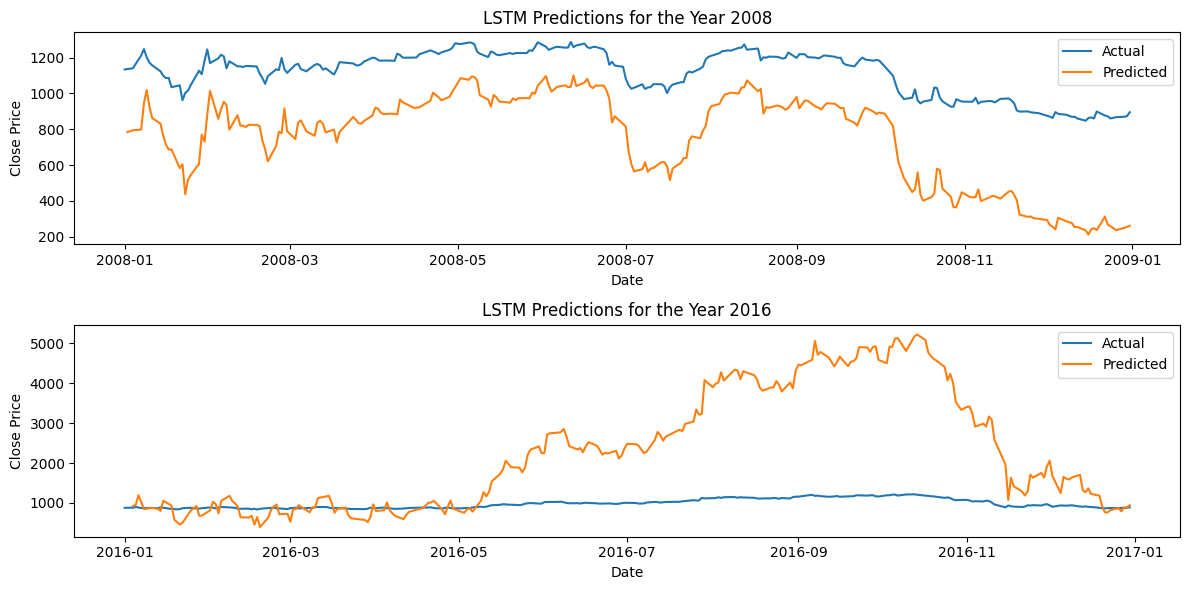

In [67]:
# Plot the predictions for 2008 and 2016 along with the actual data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.loc['2008'].index, test_data_2008, label='Actual')
plt.plot(df.loc['2008'].index[look_back:], predictions_2008, label='Predicted')
plt.title('LSTM Predictions for the Year 2008')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.subplot(2, 1, 2)
plt.plot(df.loc['2016'].index, test_data_2016, label='Actual')
plt.plot(df.loc['2016'].index[look_back:], predictions_2016, label='Predicted')
plt.title('LSTM Predictions for the Year 2016')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()